# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [6]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [7]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-07-01 11:11:02,276] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [8]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [9]:
env.close()

If you ran the simulation above, we can look at the rewards:

In [10]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [11]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        assert batch_size <= len(self.buffer)
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [14]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
#     env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 9.0 Training loss: 1.0307 Explore P: 0.9991
Episode: 2 Total reward: 23.0 Training loss: 1.0598 Explore P: 0.9968
Episode: 3 Total reward: 13.0 Training loss: 1.1429 Explore P: 0.9956
Episode: 4 Total reward: 17.0 Training loss: 1.1047 Explore P: 0.9939
Episode: 5 Total reward: 12.0 Training loss: 1.1009 Explore P: 0.9927
Episode: 6 Total reward: 22.0 Training loss: 1.1234 Explore P: 0.9905
Episode: 7 Total reward: 17.0 Training loss: 1.0976 Explore P: 0.9889
Episode: 8 Total reward: 19.0 Training loss: 1.0996 Explore P: 0.9870
Episode: 9 Total reward: 17.0 Training loss: 1.1121 Explore P: 0.9854
Episode: 10 Total reward: 34.0 Training loss: 1.0698 Explore P: 0.9820
Episode: 11 Total reward: 12.0 Training loss: 0.9848 Explore P: 0.9809
Episode: 12 Total reward: 29.0 Training loss: 1.0961 Explore P: 0.9781
Episode: 13 Total reward: 14.0 Training loss: 1.2227 Explore P: 0.9767
Episode: 14 Total reward: 13.0 Training loss: 1.1217 Explore P: 0.9755
Episode: 15 Tota

Episode: 117 Total reward: 39.0 Training loss: 26.2568 Explore P: 0.8175
Episode: 118 Total reward: 26.0 Training loss: 4.8479 Explore P: 0.8155
Episode: 119 Total reward: 23.0 Training loss: 38.8987 Explore P: 0.8136
Episode: 120 Total reward: 19.0 Training loss: 39.8125 Explore P: 0.8121
Episode: 121 Total reward: 17.0 Training loss: 30.5067 Explore P: 0.8107
Episode: 122 Total reward: 34.0 Training loss: 46.8442 Explore P: 0.8080
Episode: 123 Total reward: 15.0 Training loss: 74.4569 Explore P: 0.8068
Episode: 124 Total reward: 10.0 Training loss: 65.9886 Explore P: 0.8060
Episode: 125 Total reward: 11.0 Training loss: 33.4406 Explore P: 0.8051
Episode: 126 Total reward: 20.0 Training loss: 24.8604 Explore P: 0.8035
Episode: 127 Total reward: 12.0 Training loss: 91.1013 Explore P: 0.8026
Episode: 128 Total reward: 15.0 Training loss: 52.2941 Explore P: 0.8014
Episode: 129 Total reward: 17.0 Training loss: 19.9983 Explore P: 0.8001
Episode: 130 Total reward: 22.0 Training loss: 3.519

Episode: 235 Total reward: 41.0 Training loss: 0.8177 Explore P: 0.6756
Episode: 236 Total reward: 15.0 Training loss: 8.4923 Explore P: 0.6746
Episode: 237 Total reward: 57.0 Training loss: 30.1347 Explore P: 0.6708
Episode: 238 Total reward: 36.0 Training loss: 30.2261 Explore P: 0.6685
Episode: 239 Total reward: 11.0 Training loss: 8.3286 Explore P: 0.6677
Episode: 240 Total reward: 30.0 Training loss: 0.7853 Explore P: 0.6658
Episode: 241 Total reward: 58.0 Training loss: 7.6825 Explore P: 0.6620
Episode: 242 Total reward: 9.0 Training loss: 22.3522 Explore P: 0.6614
Episode: 243 Total reward: 13.0 Training loss: 15.7202 Explore P: 0.6605
Episode: 244 Total reward: 111.0 Training loss: 15.1777 Explore P: 0.6534
Episode: 245 Total reward: 48.0 Training loss: 1.2525 Explore P: 0.6503
Episode: 246 Total reward: 62.0 Training loss: 13.1500 Explore P: 0.6463
Episode: 247 Total reward: 63.0 Training loss: 17.0805 Explore P: 0.6423
Episode: 248 Total reward: 89.0 Training loss: 19.8534 Ex

Episode: 348 Total reward: 79.0 Training loss: 60.0341 Explore P: 0.3858
Episode: 349 Total reward: 114.0 Training loss: 1.8006 Explore P: 0.3815
Episode: 350 Total reward: 82.0 Training loss: 1.5555 Explore P: 0.3785
Episode: 351 Total reward: 72.0 Training loss: 63.2653 Explore P: 0.3758
Episode: 352 Total reward: 96.0 Training loss: 17.2691 Explore P: 0.3723
Episode: 353 Total reward: 51.0 Training loss: 26.9114 Explore P: 0.3705
Episode: 354 Total reward: 104.0 Training loss: 82.9086 Explore P: 0.3668
Episode: 355 Total reward: 38.0 Training loss: 26.5808 Explore P: 0.3654
Episode: 356 Total reward: 95.0 Training loss: 166.0903 Explore P: 0.3621
Episode: 357 Total reward: 38.0 Training loss: 16.9363 Explore P: 0.3607
Episode: 358 Total reward: 64.0 Training loss: 4.8100 Explore P: 0.3585
Episode: 359 Total reward: 101.0 Training loss: 2.4086 Explore P: 0.3550
Episode: 360 Total reward: 106.0 Training loss: 18.8338 Explore P: 0.3513
Episode: 361 Total reward: 90.0 Training loss: 64.

Episode: 461 Total reward: 199.0 Training loss: 0.6482 Explore P: 0.0849
Episode: 462 Total reward: 199.0 Training loss: 0.2713 Explore P: 0.0834
Episode: 463 Total reward: 199.0 Training loss: 371.4456 Explore P: 0.0820
Episode: 464 Total reward: 199.0 Training loss: 0.3675 Explore P: 0.0805
Episode: 465 Total reward: 199.0 Training loss: 0.5340 Explore P: 0.0791
Episode: 466 Total reward: 199.0 Training loss: 0.3484 Explore P: 0.0778
Episode: 467 Total reward: 199.0 Training loss: 0.2671 Explore P: 0.0764
Episode: 468 Total reward: 199.0 Training loss: 0.2481 Explore P: 0.0751
Episode: 469 Total reward: 199.0 Training loss: 0.6305 Explore P: 0.0739
Episode: 470 Total reward: 199.0 Training loss: 16.6229 Explore P: 0.0726
Episode: 471 Total reward: 199.0 Training loss: 0.2770 Explore P: 0.0714
Episode: 472 Total reward: 199.0 Training loss: 0.3328 Explore P: 0.0702
Episode: 473 Total reward: 199.0 Training loss: 0.2945 Explore P: 0.0690
Episode: 474 Total reward: 199.0 Training loss: 

Episode: 574 Total reward: 199.0 Training loss: 0.1409 Explore P: 0.0180
Episode: 575 Total reward: 199.0 Training loss: 0.2580 Explore P: 0.0179
Episode: 576 Total reward: 199.0 Training loss: 235.7713 Explore P: 0.0177
Episode: 577 Total reward: 199.0 Training loss: 0.1612 Explore P: 0.0176
Episode: 578 Total reward: 199.0 Training loss: 0.1397 Explore P: 0.0174
Episode: 579 Total reward: 199.0 Training loss: 0.1839 Explore P: 0.0173
Episode: 580 Total reward: 199.0 Training loss: 0.1780 Explore P: 0.0171
Episode: 581 Total reward: 199.0 Training loss: 0.2397 Explore P: 0.0170
Episode: 582 Total reward: 198.0 Training loss: 0.2327 Explore P: 0.0169
Episode: 583 Total reward: 199.0 Training loss: 0.1443 Explore P: 0.0167
Episode: 584 Total reward: 199.0 Training loss: 0.2444 Explore P: 0.0166
Episode: 585 Total reward: 199.0 Training loss: 0.1622 Explore P: 0.0165
Episode: 586 Total reward: 199.0 Training loss: 0.1341 Explore P: 0.0163
Episode: 587 Total reward: 199.0 Training loss: 2

Episode: 686 Total reward: 199.0 Training loss: 0.1286 Explore P: 0.0109
Episode: 687 Total reward: 199.0 Training loss: 226.6708 Explore P: 0.0108
Episode: 688 Total reward: 199.0 Training loss: 0.1260 Explore P: 0.0108
Episode: 689 Total reward: 199.0 Training loss: 0.1656 Explore P: 0.0108
Episode: 690 Total reward: 199.0 Training loss: 0.1422 Explore P: 0.0108
Episode: 691 Total reward: 199.0 Training loss: 0.2210 Explore P: 0.0108
Episode: 692 Total reward: 199.0 Training loss: 0.2691 Explore P: 0.0108
Episode: 693 Total reward: 199.0 Training loss: 0.1688 Explore P: 0.0108
Episode: 694 Total reward: 199.0 Training loss: 443.0528 Explore P: 0.0107
Episode: 695 Total reward: 199.0 Training loss: 0.1419 Explore P: 0.0107
Episode: 696 Total reward: 199.0 Training loss: 227.1870 Explore P: 0.0107
Episode: 697 Total reward: 199.0 Training loss: 0.1678 Explore P: 0.0107
Episode: 698 Total reward: 199.0 Training loss: 0.1522 Explore P: 0.0107
Episode: 699 Total reward: 199.0 Training los

Episode: 799 Total reward: 11.0 Training loss: 7.4447 Explore P: 0.0102
Episode: 800 Total reward: 11.0 Training loss: 5.0414 Explore P: 0.0102
Episode: 801 Total reward: 10.0 Training loss: 4.0138 Explore P: 0.0102
Episode: 802 Total reward: 12.0 Training loss: 4.2211 Explore P: 0.0102
Episode: 803 Total reward: 10.0 Training loss: 4.5754 Explore P: 0.0102
Episode: 804 Total reward: 9.0 Training loss: 2.4088 Explore P: 0.0102
Episode: 805 Total reward: 10.0 Training loss: 3.8988 Explore P: 0.0102
Episode: 806 Total reward: 12.0 Training loss: 674.2947 Explore P: 0.0102
Episode: 807 Total reward: 11.0 Training loss: 1.8484 Explore P: 0.0102
Episode: 808 Total reward: 16.0 Training loss: 1.9763 Explore P: 0.0102
Episode: 809 Total reward: 199.0 Training loss: 0.3100 Explore P: 0.0102
Episode: 810 Total reward: 199.0 Training loss: 0.5026 Explore P: 0.0102
Episode: 811 Total reward: 199.0 Training loss: 0.5902 Explore P: 0.0101
Episode: 812 Total reward: 199.0 Training loss: 0.8036 Explo

Episode: 912 Total reward: 199.0 Training loss: 2.6534 Explore P: 0.0101
Episode: 913 Total reward: 199.0 Training loss: 0.8425 Explore P: 0.0101
Episode: 914 Total reward: 199.0 Training loss: 1.6859 Explore P: 0.0101
Episode: 915 Total reward: 199.0 Training loss: 0.7986 Explore P: 0.0100
Episode: 916 Total reward: 199.0 Training loss: 76.6594 Explore P: 0.0100
Episode: 917 Total reward: 199.0 Training loss: 0.5175 Explore P: 0.0100
Episode: 918 Total reward: 199.0 Training loss: 156.5762 Explore P: 0.0100
Episode: 919 Total reward: 199.0 Training loss: 0.9479 Explore P: 0.0100
Episode: 920 Total reward: 199.0 Training loss: 0.6983 Explore P: 0.0100
Episode: 921 Total reward: 199.0 Training loss: 0.8771 Explore P: 0.0100
Episode: 922 Total reward: 199.0 Training loss: 273.4854 Explore P: 0.0100
Episode: 923 Total reward: 199.0 Training loss: 248.3914 Explore P: 0.0100
Episode: 924 Total reward: 199.0 Training loss: 0.5437 Explore P: 0.0100
Episode: 925 Total reward: 199.0 Training lo

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

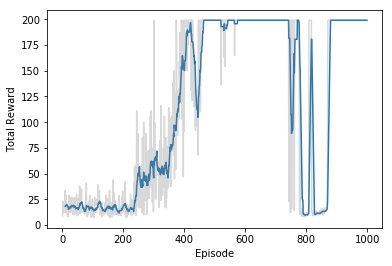

In [18]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [19]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [14]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.